In [ ]:
'''Massive import statement (20-30s)'''
import pandas as pd
import os
import numpy as np
from numpy import where, unique
import glob
from bioinfokit import analys, visuz
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import umap
from sklearn.datasets import load_digits, make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
from scipy.stats import randint
from IPython.display import Image
import graphviz
import hdbscan
from mpl_toolkits.mplot3d import Axes3D 
import shutil
from cmapPy.pandasGEXpress.parse_gct import parse
import anndata as an
import scanpy as sc
from Ensembl_converter import EnsemblConverter

In [ ]:
'''Converts a GDC samplesheet to dataframe and extracts only primary tumor samples'''
compress = pd.read_csv('samplesheet.tsv', sep='\t', header=0)
comp = compress[['File ID', 'Project ID', 'Sample ID', 'Case ID']]
comp.set_index('File ID', inplace=True)
comp = comp.loc[comp['Sample ID'].str.startswith('TCGA')]
comp = comp.loc[comp['Sample ID'].str.endswith('-01A')]
comp['Project ID'] = comp['Project ID'].str.replace('TCGA-','')
comp.to_csv('clinicalinfo.tsv', sep='\t')

'''NAT samples also collected but not used'''
natsamples = compress[['File ID', 'Project ID', 'Case ID', 'Sample Type']]
natsamples.set_index('File ID', inplace=True)
natsamples = natsamples.loc[natsamples['Case ID'].str.startswith('TCGA')]
natsamples = natsamples.loc[natsamples['Sample Type'] == 'Solid Tissue Normal']
natsamples['Project ID'] = natsamples['Project ID'].str.replace('TCGA-','')
natsamples.to_csv('NATinfo.tsv', sep='\t')

# Get list of gencode V36 lncRNA
for directory in os.listdir("./local/")[:1]:
    file = glob.glob(f'./local/{directory}/*.tsv')[0]
transcript = pd.read_csv(file, sep='\t', header=1,index_col=0, usecols=['gene_id','gene_type','fpkm_unstranded'])
transcript = transcript.loc[(transcript['gene_type']=='lncRNA')]
lncRNAs = transcript.index

In [ ]:
'''Extracts all TCGA data. Very slow (1 hour runtime)'''
#All GDC downloaded files should be in a folder named 'local' in the working directory
iter = 0
uuids = os.listdir("./local/")
total =len(uuids)
print(f'Listing Done: {total}')
allsamples = pd.DataFrame(index=lncRNAs, columns=uuids)
donesofar = []
print('Memory Allocated')
for directory in uuids:
    file = glob.glob(f'./local/{directory}/*.tsv')[0]
    uuid = str(directory)
    transcriptome = pd.read_csv(file, sep='\t', header=1,index_col=0, usecols=['gene_id','gene_type','tpm_unstranded'])
    transcriptome = transcriptome.loc[(transcriptome['gene_type']=='lncRNA')]
    transcriptome = transcriptome['tpm_unstranded'].rename(uuid)
    allsamples[uuid] = transcriptome
    donesofar.append(uuid)
    iter +=1
    if iter % 200 ==0:
        print(f'Progress = {round((iter/total)*100, 2)}%, File is {iter} entries long')

allsamples.to_csv("TCGAlncRNA.tsv", sep= '\t')
print(f'Progress = {round((iter/total)*100, 2)}%, File is {iter} entries long')
columnstoextract = set(allsamples.columns).difference(natsamples.index)
natvalues= allsamples.drop(columnstoextract, axis=1)
natvalues.to_csv("TCGA NAT lncRNA.tsv", sep= '\t')
columnstoremove = set(allsamples.columns).difference(comp.index)
allsamples.drop(columnstoremove, axis=1, inplace=True)
allsamples.to_csv("TCGAlncRNA.tsv", sep= '\t')

In [ ]:
'''Loads Everything - 10 minute runtime'''
allsamples =pd.read_csv("TCGAlncRNA.tsv", sep= '\t', index_col=0)
natsamples =pd.read_csv("TCGA NAT lncRNA.tsv", sep= '\t',index_col=0)
matchdict = pd.read_csv("cancer type tissue match.txt", sep='\t', index_col=0)
matchdict.dropna(subset='GTEx tissue', inplace=True)
matchdict = matchdict.apply(lambda x: x.str.split(' ').str[0])
matchdict = dict(matchdict['GTEx tissue'])
# store cancer acronyms
cancerIDs = comp['Project ID'].unique()
# Get tissue data
tissuefiles = os.listdir('./datafiles/tissues/')
testtissue = parse(f'./datafiles/tissues/{tissuefiles[1]}', rid=list(lncRNAs)).data_df
alltissues = pd.DataFrame(index=testtissue.index)
for tissue in tissuefiles:
    name = tissue.split('_')[4:5]
    name = [tissuecode.replace('.gct','') for tissuecode in name][0].capitalize()
    tissuedata = parse(f'./datafiles/tissues/{tissue}', rid=list(lncRNAs)).data_df
    tissuedata.columns = [name for x in tissuedata.columns]
    alltissues = alltissues.join(tissuedata)
# Rectify to Gencode V36-V39 intersection
lncRNAtodrop = set(lncRNAs).difference(set(testtissue.index))
gencodematch = allsamples.drop(lncRNAtodrop)
natsamplesmatched = natsamples.drop(lncRNAtodrop)
# Creates separate files for each cancer type, loses patient ID as it renames all columns to the cancer type
cancertypes = matchdict.keys()
allcancertypedata = pd.DataFrame(index=gencodematch.index)
for cancer in cancertypes:
    # This throws a warning as all samples are renamed to their type
    samplesoftype = comp.loc[comp['Project ID'].str.endswith(cancer)]
    samplesoftype = gencodematch[samplesoftype.index]
    samplesoftype.columns = [cancer for x in samplesoftype.columns]
    allcancertypedata = allcancertypedata.join(samplesoftype)
# Creates Annotated DataFrames
adata = an.AnnData(allcancertypedata.T)
adata.obs['Cancer Type'] = pd.Categorical(adata.obs_names)
tissueadata = an.AnnData(alltissues.T)
tissueadata.obs['Tissue Type'] = pd.Categorical(tissueadata.obs_names)
adata.obs['Matched Tissue'] =pd.Categorical([matchdict[cancer] for cancer in adata.obs_names])

c:\Users\sjobl\.conda\envs\cb2030-labs\Lib\site-packages\cmapPy\pandasGEXpress\parse_gct.py:251: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  row_metadata = row_metadata.apply(lambda x: pd.to_numeric(x, errors="ignore"))
c:\Users\sjobl\.conda\envs\cb2030-labs\Lib\site-packages\cmapPy\pandasGEXpress\parse_gct.py:277: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  col_metadata = col_metadata.apply(lambda x: pd.to_numeric(x, errors="ignore"))
c:\Users\sjobl\.conda\envs\cb2030-labs\Lib\site-packages\cmapPy\pandasGEXpress\parse_gct.py:251: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  row_metadata = row_metadata.apply(lambda x: pd.to_numeric(x, e

In [ ]:
# Itemized differential gene expression analysis
sc.tl.rank_genes_groups(adata, groupby='Cancer Type', method='wilcoxon', corr_method='bonferroni')
sc.tl.rank_genes_groups(tissueadata, groupby='Tissue Type', method='wilcoxon', corr_method='bonferroni')
cancerspecific = sc.get.rank_genes_groups_df(adata, pval_cutoff=0.01, log2fc_min=1, group=None)
tissuespecific = sc.get.rank_genes_groups_df(tissueadata, pval_cutoff=0.01, log2fc_min=1, group=None)
howmanyshared = pd.DataFrame(index=matchdict.keys(), columns=['Shared with tissue'])
geneframe = dict() # Provides a dictionary of cancer type and its list of top genes
shared = dict() # Provides genes shared between cancer and tissue
'''The algorithm'''

for cancer in matchdict.keys(): # This loop harvests top 100 differentially expressed genes and makes sure they are not simply tissue enriched
    cancertop100 = (cancerspecific.loc[cancerspecific['group']==cancer].iloc[:100])['names']
    tissuetop100 = (tissuespecific.loc[tissuespecific['group']==matchdict[cancer]].iloc[:100])['names']
    # Removing Tissue enriched
    todrop = list(set(cancertop100).intersection(set(tissuetop100)))
    cancertop100.index = cancertop100.values
    cancertop100.drop(todrop, inplace=True)
    howmanyshared.loc[howmanyshared.index==cancer] = len(todrop)
    shared[cancer] = todrop
    geneframe[cancer] = cancertop100.values 

for cancer in list(geneframe.keys()): # This loop checks for mutualism with other cancers and drops any mutual genes
    keys = set(geneframe.keys())
    excludesitself= set([cancer])
    banlist = []
    for key in keys.difference(excludesitself): # extracts the genelists of all other cancers
        # gives list of genelists for removal from others dataset.
        banlist.append(geneframe[key])
    banlist = set([gene for othercancer in banlist for gene in othercancer]) # Turns the nested list provided from the dictionary into one long list
    dropped = set(geneframe[cancer]).intersection(banlist)
    retained = pd.DataFrame(index=geneframe[cancer]).drop(dropped).index
    geneframe[cancer]=retained # Updates the gene list dictionary

colnamesfortop=['group','names','scores','logfoldchanges','pvals','pvals_adj']
bestgenes = pd.DataFrame(columns=colnamesfortop)
reallysmall = pd.DataFrame(columns=colnamesfortop)
bestgenedict = dict()
smallgenedict = dict()
alltops= pd.DataFrame(columns=colnamesfortop)
# This loop extracts the final candidates
for cancer in list(geneframe.keys()):
    # Isolates only the correct genes
    topgenes = cancerspecific.loc[cancerspecific['group']==cancer]
    topgenes = topgenes.loc[topgenes['names'].isin(geneframe[cancer].values)]
    top5lfc = topgenes.sort_values('logfoldchanges',ascending=False)[:5]
    # Final collection, these lists will be used for visualization.
    alltops =  pd.concat([alltops, topgenes], axis=0)
    bestgenes = pd.concat([bestgenes,top5lfc], axis=0)
    reallysmall = pd.concat([reallysmall, top5lfc[:1]])
    bestgenedict[cancer] = list(top5lfc['names'])
    smallgenedict[cancer] = list(top5lfc['names'][:2])

# Killing temp variables, we will need the RAM
del cancertop100,tissuetop100,todrop,keys,excludesitself,banlist,dropped,retained,top5lfc 

c:\Users\sjobl\.conda\envs\cb2030-labs\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
c:\Users\sjobl\.conda\envs\cb2030-labs\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
c:\Users\sjobl\.conda\envs\cb2030-labs\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:463: PerformanceWarning: DataFram

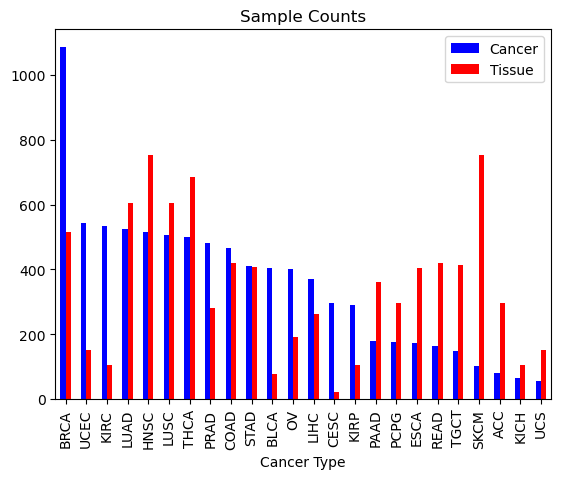

In [6]:
sampleframe = pd.DataFrame(columns=['Cancer', 'Tissue'])
samplecounts = tissueadata.obs.value_counts()
matchcounts = adata.obs['Cancer Type'].value_counts()
sampleframe['Cancer'] = matchcounts
sampleframe['Tissue'] = [samplecounts[matchdict[cancer]] for cancer in sampleframe.index]
fig = sampleframe.plot.bar(color=['b','r'])
fig.set_title('Sample Counts')
plt.show()

In [ ]:
'''Random Forest with CV'''
# Test Split
train, test= train_test_split(allcancertypedata.T,stratify=allcancertypedata.T.index, random_state=13)
forest = RandomForestClassifier(random_state=16, n_estimators=411, max_depth=19)
forest.fit(train.values,train.index)
predict = forest.predict(test.values)
accscore = accuracy_score(test.index, predict)
print(accscore)
# Tuning
param_dist = {'n_estimators': randint(50,500),'max_depth': randint(1,20)}
forhyperparams = RandomForestClassifier(random_state=13)
crossval = RandomizedSearchCV(forhyperparams, param_dist, n_iter=5, cv=5)
crossval.fit(train.values,train.index)
bestmodel = crossval.best_estimator_
bestparams = crossval.best_params_
print(bestparams) 


0.9206798866855525


0.9206798866855525
0.9090837823657834
0.9206798866855525


c:\Users\sjobl\.conda\envs\cb2030-labs\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


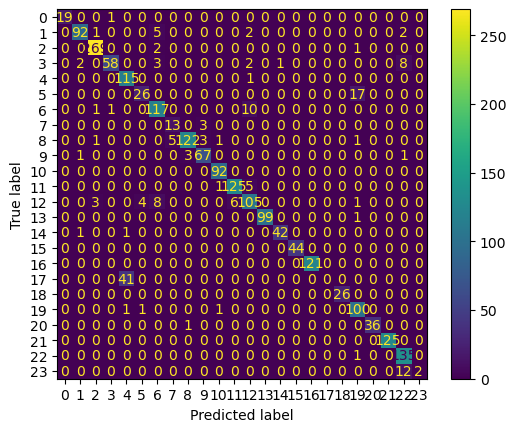

In [10]:
predictcv = bestmodel.predict(test.values)
confmat = confusion_matrix(test.index, predictcv)
# Metrics
ConfusionMatrixDisplay(confusion_matrix=confmat).plot()
print(accuracy_score(test.index, predictcv))
print(precision_score(test.index, predictcv, average='weighted'))
print(recall_score(test.index, predictcv,average='weighted'))

Shared with top 120 21
Shared with all top genes 973


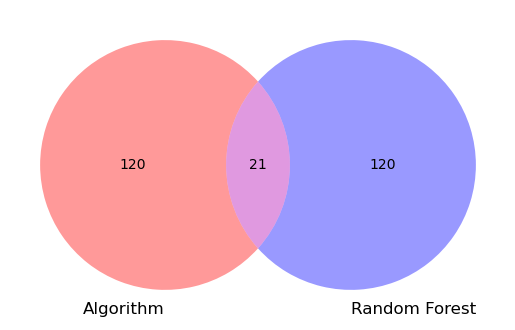

In [11]:
feature_importances = pd.Series(bestmodel.feature_importances_, index=train.columns).sort_values(ascending=False)[:120]
top5shared = len(set(feature_importances.index).intersection(set(bestgenes['names'])))
print('Shared with top 120',top5shared)
# feature_importances.plot.bar(figsize=(19,3), title='Feature Importances - Random Forest', fontsize=8)
featured = pd.Series(bestmodel.feature_importances_, index=train.columns).sort_values(ascending=False)[:1681]
topshared = len(set(featured.index).intersection(set(alltops['names'])))
print('Shared with all top genes',topshared)
# venn2(subsets=(len(alltops['names']), len(featured.index),topshared), set_labels=('Algorithm','Random Forest'), set_colors=('r','b'))
venn2(subsets=(len(bestgenes['names']), len(feature_importances.index),top5shared), set_labels=('Algorithm','Random Forest'), set_colors=('r','b'))


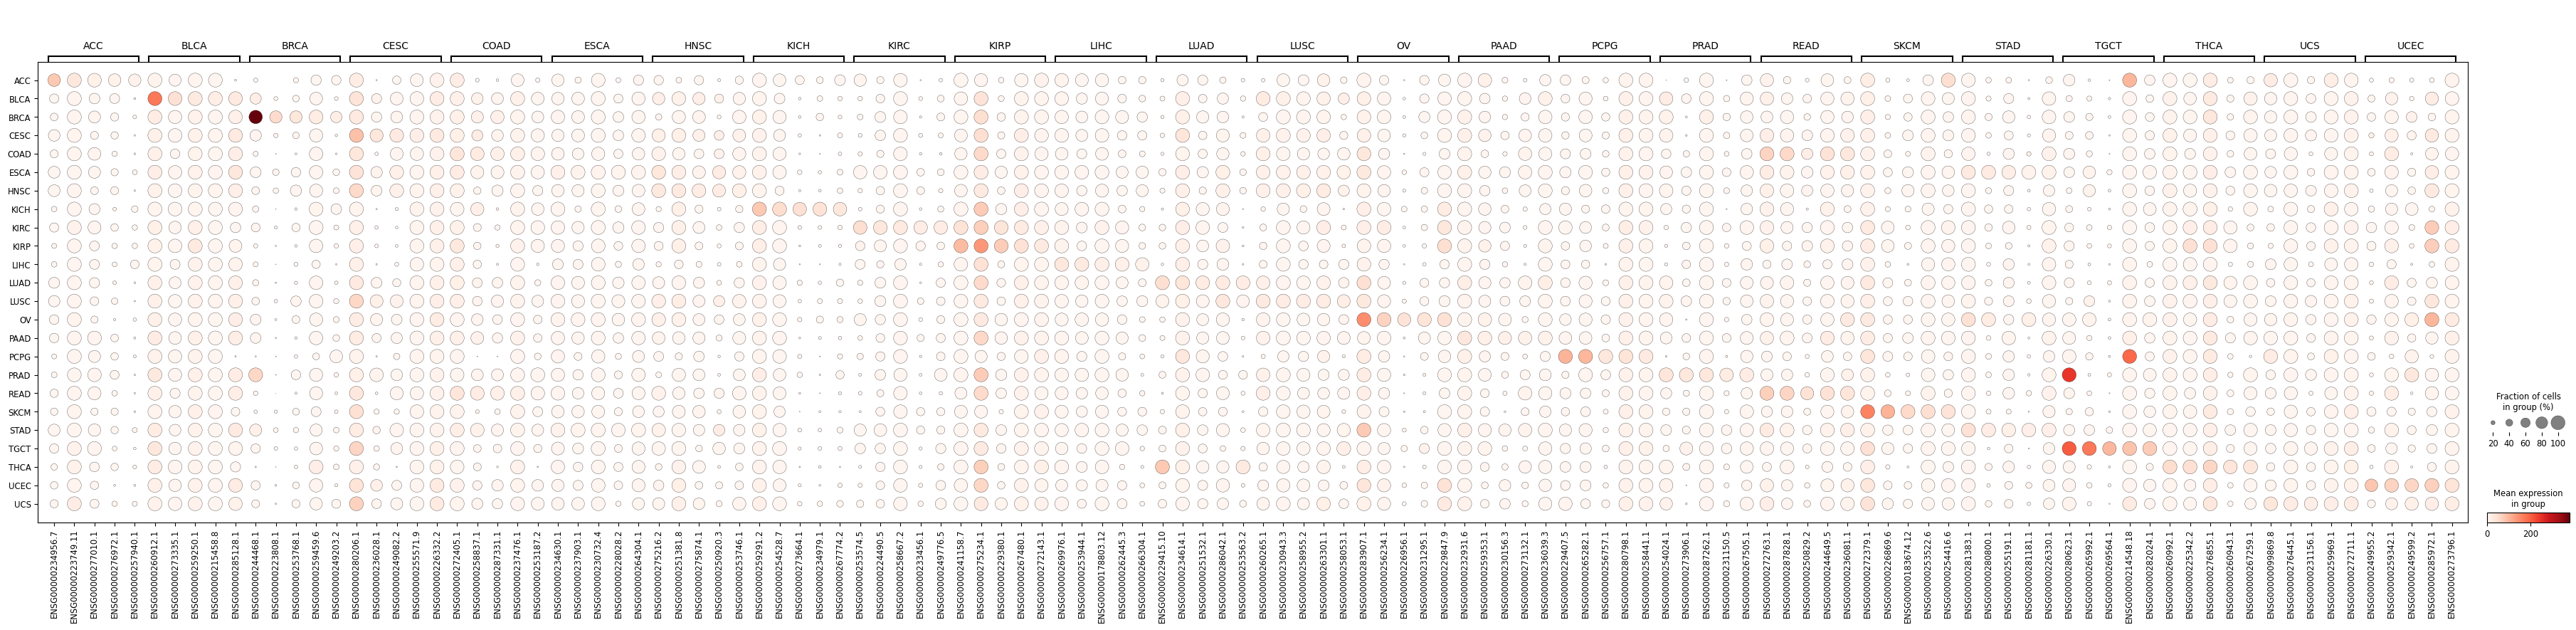

In [34]:
sc.pl.dotplot(adata, bestgenedict, groupby='Cancer Type')

c:\Users\sjobl\.conda\envs\cb2030-labs\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\sjobl\.conda\envs\cb2030-labs\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\sjobl\.conda\envs\cb2030-labs\Lib\site-packages\scanpy\tools\_utils.py:40: UserWarning: You’re trying to run this on 1681 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
c:\Users\sjobl\.conda\envs\cb2030-labs\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\sjobl\.conda\envs\cb2030-labs\L

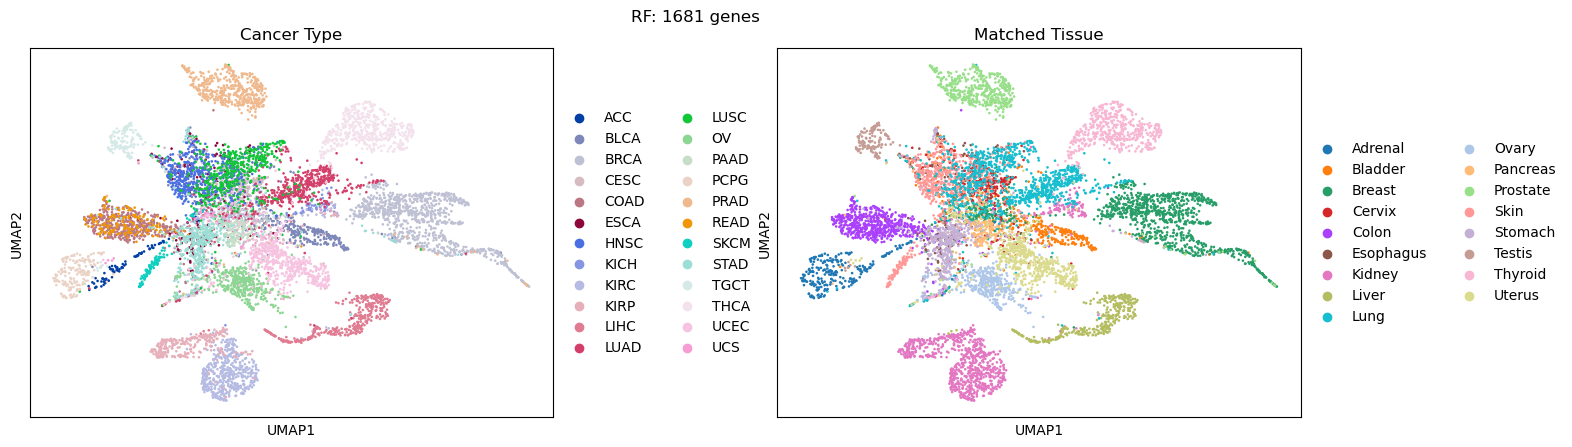

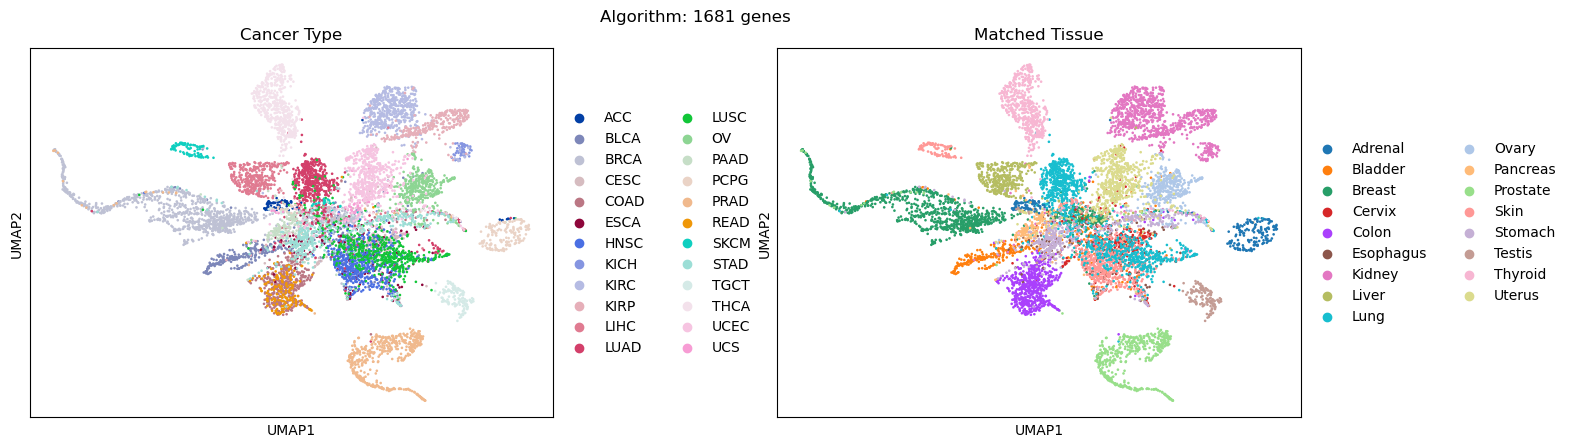

In [13]:
def umapgenelist(genelist=list(adata.var_names), dataset=adata, title=''):
    extractsmall = dataset[:, genelist]
    sc.pp.neighbors(extractsmall)
    sc.tl.umap(extractsmall,min_dist=0.5 ,random_state=42)
    if dataset is adata:
        fig = sc.pl.umap(extractsmall, color=['Cancer Type','Matched Tissue'],wspace=0.3, show=False)
        plt.suptitle(f'{title}: {len(genelist)} genes')
    else:
        sc.pl.umap(extractsmall, color='Tissue Type')
        
umapgenelist(list(featured.index),title='RF')
umapgenelist(list(alltops['names']),title='Algorithm')
# umapgenelist(title= 'All')


In [ ]:
'''Ensembl name fetcher for the tippy top lncRNA'''
subset = bestgenes.loc[bestgenes['logfoldchanges']>100]
genelist = subset['names'].str.split('.')
genelist = [listitem[0] for listitem in genelist]
converter = EnsemblConverter()
result = converter.convert_ids(genelist)
result.to_csv('geneids.tsv', sep='\t')
